In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

El objetivo de este notebook es reproducir los gráficos utilizados para la clase de Sesgo y Varianza. No se propone ningún ejercicio, pero puede ser educativo reproducir los gráficos.

# Dicotomía de Sesgo y Varianza


In [55]:
N_SAMPLES = 20
x = np.linspace(0,1,num=N_SAMPLES).reshape(-1,1)

def ground_truth(x):
    return 4 * x+ np.sin(x*6)

N_REPEAT = 50

all_data = np.empty([N_REPEAT, N_SAMPLES])

# Repeat realization of data many times
for i in range(N_REPEAT):
    t =  ground_truth(x.flatten()) + 0.5*np.random.randn(N_SAMPLES)
#     x_train, x_test, t_train, t_test = train_test_split(x, t)
    
    all_data[i] = t

In [56]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

def ridge(m, ll):
    """
    Construct a pipeline for ridge regression.
    
    :param int m: degree of the polynomial features
    :param float ll: regularization coefficient lambda.
    
    Note: Ridge takes as argument alpha = lambda/2.
    """
    return Pipeline([('poly_features', PolynomialFeatures(degree=m)),
                     ('regressor', Ridge(fit_intercept=False, alpha=ll/2.))])

In [75]:
from sklearn.metrics import mean_squared_error

x_ = np.linspace(0, 1, 100).reshape(-1, 1)
lls = [0.0, 1e-3, 10.0]

all_predictions = np.empty([len(lls), N_REPEAT, len(x_)])
for i, data in enumerate(all_data):
    for j, ll in enumerate(lls):
        reg = ridge(9, ll)
        reg.fit(x, data)
        all_predictions[j, i] = reg.predict(x_)

In [76]:
print(all_predictions.shape)

(3, 50, 100)


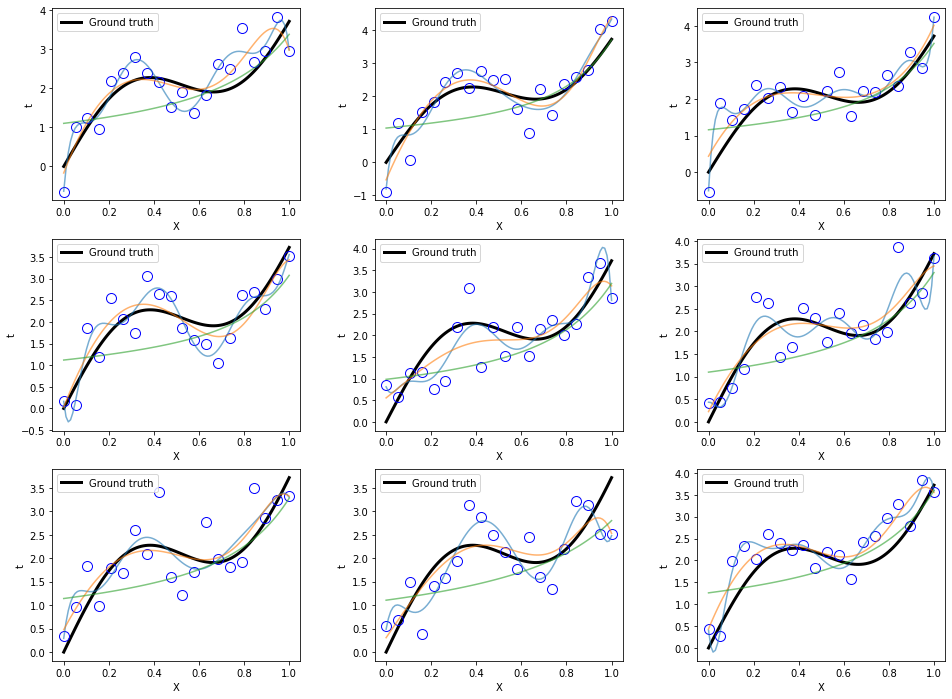

In [81]:
n_columns = 3
N_ROWS = 3

assert n_columns * N_ROWS < len(all_data), 'Not enough simulated datasets'

fig = plt.figure(figsize=(16, 4 * N_ROWS))
axs = fig.subplots(ncols=n_columns, nrows=N_ROWS, gridspec_kw={'wspace': 0.3})

# randomly choose simulations to draw
ind = np.arange(all_predictions.shape[1])
np.random.shuffle(ind)

for i, ax in enumerate(axs.flatten()):
    # Plot ground truth
    ax.plot(x_, ground_truth(x_), color='k', lw=3, label='Ground truth')
    
    # Plot data
    ax.plot(x, all_data[ind[i]], 'ob', mfc='none', ms=10)
    
    ax.legend(loc=0)
    
    for j in range(len(lls)):
        ax.plot(x_, all_predictions[j, ind[i]], alpha=0.6, 
                label='$\lambda = {:.1e}$'.format(lls[j]))
    
    
    #Label
    ax.set_xlabel('X')
    ax.set_ylabel('t')

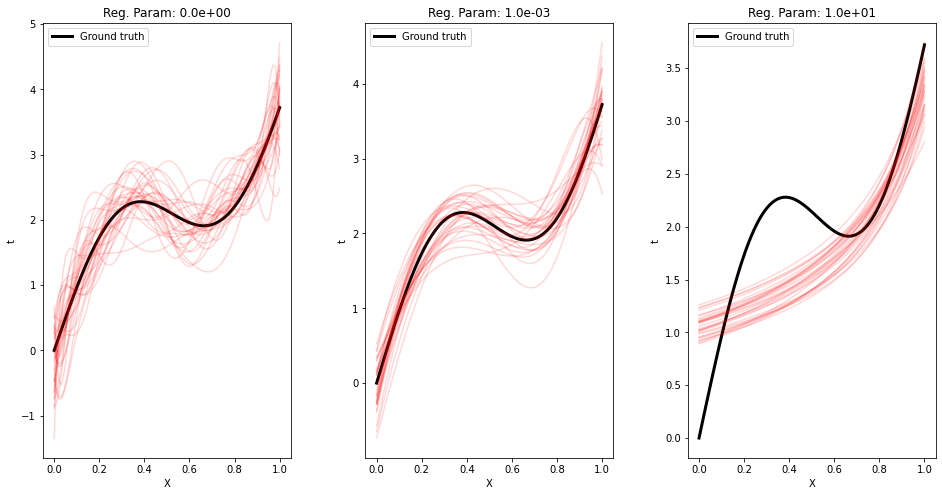

In [61]:
N_PLOT = 30

fig = plt.figure(figsize=(16, 8))
axs = fig.subplots(nrows=1, ncols=3, gridspec_kw={'wspace': 0.3})

# randomly choose simulations to draw
ind = np.arange(all_predictions.shape[1])
np.random.shuffle(ind)

for i, ax in enumerate(axs):
    ax.plot(x_, ground_truth(x_), color='k', lw=3, label='Ground truth')
    ax.plot(x_, all_predictions[i, ind[:N_PLOT]].T, color='Red', alpha=0.15)
    ax.legend(loc=0)
    
    #Label
    ax.set_xlabel('X')
    ax.set_ylabel('t')
    
    # Title
    axs[i].set_title('Reg. Param: {:.1e}'.format(lls[i]))

## Cálculo completo de Sesgo y Varianza

In [62]:

# Repetir para una grilla mas fina de lambdas
lls = np.logspace(-5, np.log10(5), 40)
lls = np.concatenate([np.array([0,]), lls])

all_predictions_full = np.empty([len(lls), N_REPEAT, len(x_)])
for i, data in enumerate(all_data):
    for j, ll in enumerate(lls):
        reg = ridge(9, ll)
        reg.fit(x, data)
        all_predictions_full[j, i] = reg.predict(x_)
        
# Todas las predicciones tienen shape n_lambdas x n_repeats x len(x_)

In [63]:
all_predictions_full.shape

(41, 50, 100)

In [68]:

# Añadimos ruido a las mediciones (error irreducible)
irreduc_err = 0.1

# Calculamos la prediccion media sobre realizaciones de datasets
Ed_y = np.average(all_predictions_full, axis=1)

# Calculamos el sesgo (diferencia entre la predicción media y la verdad)
bias2 = (Ed_y - ground_truth(x_.flatten()))**2

# Varianza
var = np.mean((Ed_y[:, np.newaxis, :] - all_predictions_full)**2, axis=1)

# Error total
err = bias2 + var + irreduc_err**2

In [69]:
print(var.shape, bias2.shape, err.shape, lls.shape)

(41, 100) (41, 100) (41, 100) (41,)


Text(0, 0.5, 'Error')

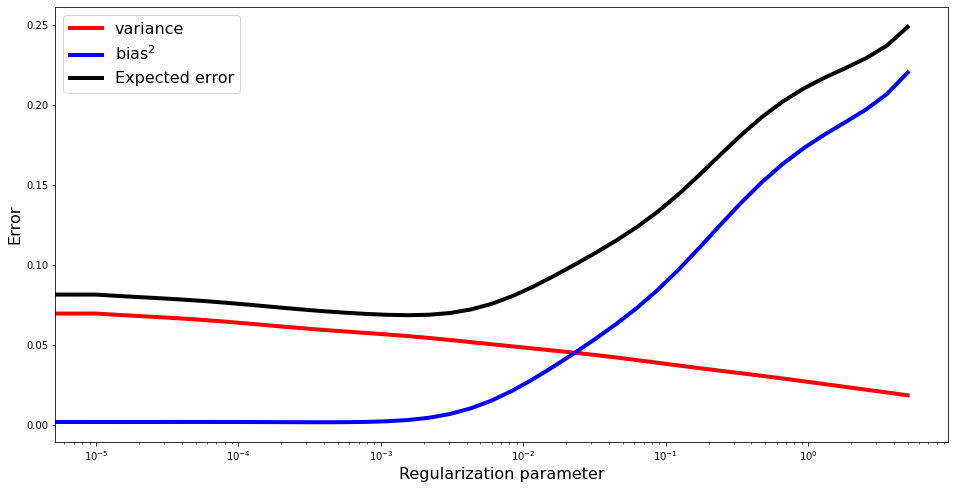

In [70]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
# Graficar en el mismo plot, promediado sobre X
ax.semilogx(lls, var.mean(axis=1), color='r', label='variance', lw=4)
ax.semilogx(lls, bias2.mean(axis=1), color='b', label='bias$^2$', lw=4)
ax.semilogx(lls, err.mean(axis=1), label='Expected error', lw=4, color='k')

# Titulo y labels
ax.legend(fontsize=16)
ax.set_xlabel('Regularization parameter', size=16)
ax.set_ylabel('Error', size=16)

# ax.invert_xaxis()